<a href="https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIP Explainability**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("../")
sys.path.append("../CLIP_explainability/Transformer-MM-Explainability/")

# **CLIP**

In [3]:
from os.path import join
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
import warnings
from torchmetrics import JaccardIndex
from collections import defaultdict
from IPython.core.display import display, HTML

warnings.filterwarnings('ignore')

In [4]:
from CLIP_explainability.utils import interpret, show_img_heatmap, show_txt_heatmap, color, _tokenizer
from clip_grounding.utils.paths import REPO_PATH
from clip_grounding.datasets.png import PNG
from clip_grounding.utils.image import pad_to_square
from clip_grounding.utils.visualize import show_grid_of_images
from clip_grounding.utils.log import tqdm_iterator

In [5]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
}

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

## Run on sample image-text pair

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with eye glasses


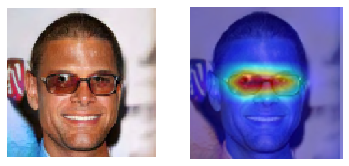

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with white teeth


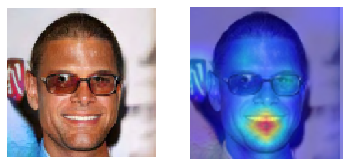

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with a nose


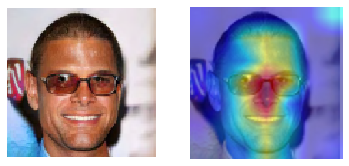

In [7]:
def show_cam(mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap
    cam = cam / np.max(cam)
    return cam


def interpret_and_generate(model, img, texts, orig_image, return_outputs=False, show=True):
    text = clip.tokenize(texts).to(device)
    R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
    batch_size = text.shape[0]
    
    outputs = []
    for i in range(batch_size):
        text_scores, text_tokens_decoded = show_txt_heatmap(texts[i], text[i], R_text[i], show=show)
        image_relevance = show_img_heatmap(R_image[i], img, orig_image=orig_image, device=device, show=show)
        plt.show()
        outputs.append({"text_scores": text_scores, "image_relevance": image_relevance, "tokens_decoded": text_tokens_decoded})
    
    if return_outputs:
        return outputs



texts = ["a man with eyeglasses", "a man with white teeth", "a man with a nose"]
img_path = join(REPO_PATH, "CLIP_explainability", "Transformer-MM-Explainability", "CLIP/glasses.png")
pil_image = Image.open(img_path)
img = preprocess(pil_image).unsqueeze(0).to(device)
outputs = interpret_and_generate(model, img, texts, pil_image, return_outputs=True)

In [8]:
len(outputs)

3

In [9]:
outputs[0].keys()

dict_keys(['text_scores', 'image_relevance', 'tokens_decoded'])

In [10]:
outputs[0]["text_scores"].shape

torch.Size([5])

In [11]:
outputs[0]["image_relevance"].shape, outputs[0]["image_relevance"].min(), outputs[0]["image_relevance"].max()

((224, 224), 0.0, 1.0)

In [12]:
outputs[0]["tokens_decoded"]

['a ', 'man ', 'with ', 'eye', 'glasses ']

## Run on `Panoptic Narrative Grounding` benchmark

In [13]:
dataset = PNG(dataset_root=join(REPO_PATH, "data", "panoptic_narrative_grounding"), split="val2017")

In [14]:
len(dataset)

8573

In [15]:
def process_entry_text_to_image(entry, unimodal=False):
    image = entry['image']
    text_mask = entry['text_mask']
    text = entry['text']
    orig_image = pad_to_square(image)

    img = preprocess(orig_image).unsqueeze(0).to(device)
    text_index = text_mask.argmax()
    texts = [text[text_index]] if not unimodal else ['']
    
    return img, texts, orig_image

#### Run on one sample from the dataset

In [16]:
idx = 9
instance = dataset[idx]

**Run text-to-image test**

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,wash basin


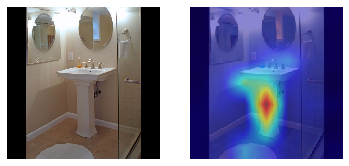

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,wash basin


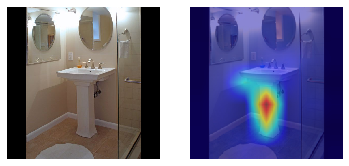

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,mirror


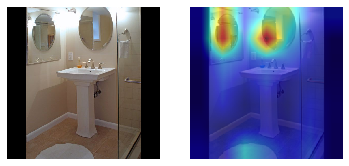

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,towel


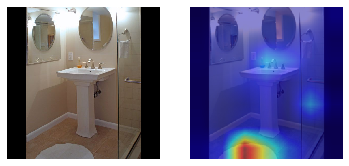

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,mirror


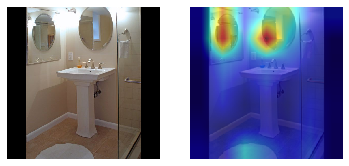

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,glass


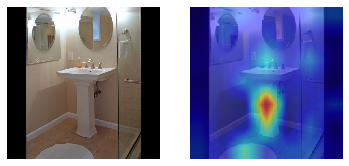

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,mat


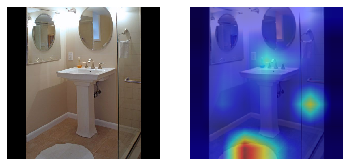

In [17]:
for entry in instance:
    test_img, test_texts, orig_image = process_entry_text_to_image(entry)
    outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True)

**Compute metric (IoU) between relevance and ground truth segmentation map**

In [18]:
jaccard = JaccardIndex(num_classes=2)
jaccard = jaccard.to(device)

In [19]:
def preprocess_ground_truth_mask(mask, resize_shape):
    mask = Image.fromarray(mask.astype(np.uint8) * 255)
    mask = pad_to_square(mask, color=0)
    mask = mask.resize(resize_shape)
    mask = np.asarray(mask) / 255.
    return mask


# sample
test_relevance_map = outputs[0]["image_relevance"].astype(np.float64)

test_ground_truth_mask = entry["image_mask"]
test_ground_truth_mask = preprocess_ground_truth_mask(test_ground_truth_mask, test_relevance_map.shape)

In [20]:
alpha = 0.3
overlaid = alpha * test_ground_truth_mask + (1 - alpha) * test_relevance_map

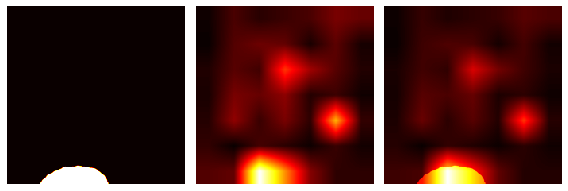

In [21]:
show_grid_of_images([test_ground_truth_mask, test_relevance_map.astype(np.float64), overlaid], cmap="hot")

### Otsu's thresholding

In [22]:
test_relevance_map.min(), test_relevance_map.max(), test_relevance_map.shape

(0.0, 1.0, (224, 224))

In [23]:
from skimage import filters

In [24]:
threshold = filters.threshold_otsu(test_relevance_map)
test_otsu_map = (test_relevance_map > threshold).astype(np.uint8)

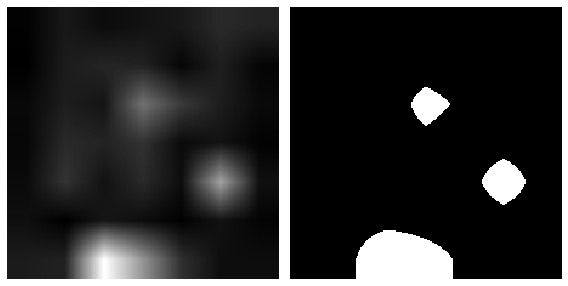

In [25]:
show_grid_of_images([test_relevance_map, test_otsu_map])

In [26]:
np.unique(test_otsu_map)

array([0, 1], dtype=uint8)

In [27]:
iou = jaccard(
    torch.from_numpy(test_relevance_map).to(device),
    torch.from_numpy(test_ground_truth_mask.astype(np.uint8)).to(device),
)
iou = iou.item()
print(iou)

0.7852946519851685


In [28]:
iou = jaccard(
    torch.from_numpy(test_otsu_map).to(device),
    torch.from_numpy(test_ground_truth_mask.astype(np.uint8)).to(device),
)
iou = iou.item()
print(iou)

0.6253611445426941


**IoU between relevance map and ground truth mask**

In [29]:
iou = jaccard(
    torch.from_numpy(test_relevance_map).to(device),
    torch.from_numpy(test_ground_truth_mask.astype(np.uint8)).to(device),
)
iou = iou.item()

In [30]:
iou

0.7852946519851685

In [31]:
def apply_otsu_threshold(relevance_map):
    threshold = filters.threshold_otsu(relevance_map)
    otsu_map = (relevance_map > threshold).astype(np.uint8)
    return otsu_map

In [32]:
def evaluate_text_to_image(dataset, debug=False):

    instance_level_metrics = defaultdict(list)
    entry_level_metrics = defaultdict(list)
    
    jaccard = JaccardIndex(num_classes=2)
    jaccard = jaccard.to(device)

    num_iter = len(dataset)
    if debug:
        num_iter = 100

    iterator = tqdm_iterator(range(num_iter), desc=f"Evaluating on {type(dataset).__name__} dataset")
    for idx in iterator:
        instance = dataset[idx]
        
        instance_iou = 0.
        for entry in instance:
            # preprocess the image and text
            test_img, test_texts, orig_image = process_entry_text_to_image(entry)
            
            # compute the relevance scores 
            outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True, show=False)
            
            # use the image relevance score to compute IoU w.r.t. ground truth segmentation masks

            # NOTE: since we pass single entry (1-sized batch), outputs[0] contains our reqd outputs
            relevance_map = outputs[0]["image_relevance"]
            otsu_relevance_map = apply_otsu_threshold(relevance_map)
            
            ground_truth_mask = entry["image_mask"]
            ground_truth_mask = preprocess_ground_truth_mask(ground_truth_mask, test_relevance_map.shape)
            
            entry_iou = jaccard(
                torch.from_numpy(otsu_relevance_map).to(device),
                torch.from_numpy(ground_truth_mask.astype(np.uint8)).to(device),
            )
            entry_iou = entry_iou.item()
            instance_iou += (entry_iou / len(entry))
            
            entry_level_metrics["iou"].append(entry_iou)
        
        # capture instance (image-sentence pair) level IoU
        instance_level_metrics["iou"].append(instance_iou)
    
    average_metrics = {k: np.mean(v) for k, v in entry_level_metrics.items()}
    
    return (
        average_metrics,
        instance_level_metrics,
        entry_level_metrics
    )

In [33]:
average_metrics, instance_level_metrics, entry_level_metrics = evaluate_text_to_image(dataset, debug=True)

Evaluating on PNG dataset: 100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


In [34]:
average_metrics

{'iou': 0.4892260574612969}

**Run image-to-text test**

In [35]:
# def process_entry_image_to_text(entry):
#     mask = np.repeat(np.expand_dims(entry['image_mask'], -1), 3, axis=-1)
#     masked_image = (mask * np.asarray(entry['image'])).astype(np.uint8)
#     masked_image = Image.fromarray(masked_image)
#     texts = [' '.join(entry['text'])]
#     orig_image = pad_to_square(masked_image)
#     img = preprocess(orig_image).unsqueeze(0).to(device)
    
#     return img, texts, orig_image

def process_entry_image_to_text(entry, unimodal=False):
    if not unimodal:
        mask = np.repeat(np.expand_dims(entry['image_mask'], -1), 3, axis=-1)
        masked_image = (mask * np.asarray(entry['image'])).astype(np.uint8)
        masked_image = Image.fromarray(masked_image)
        orig_image = pad_to_square(masked_image)
        img = preprocess(orig_image).unsqueeze(0).to(device)
    else:
        orig_image_shape = max(np.asarray(entry['image']).shape[:2])
        orig_image = Image.fromarray(np.zeros((orig_image_shape, orig_image_shape, 3), dtype=np.uint8))
#         orig_image = Image.fromarray(np.random.randint(0, 256, (orig_image_shape, orig_image_shape, 3), dtype=np.uint8))

        img = preprocess(orig_image).unsqueeze(0).to(device)

    texts = [' '.join(entry['text'])]

    return img, texts, orig_image

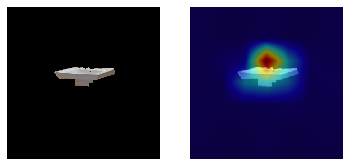

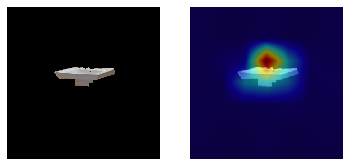

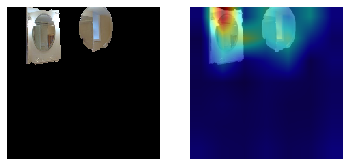

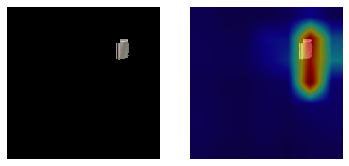

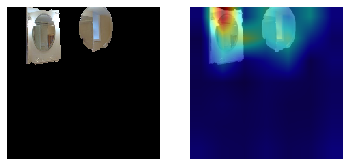

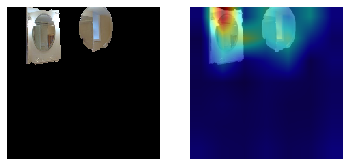

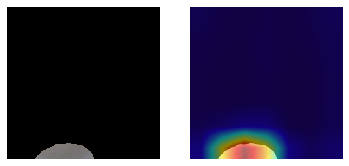

In [36]:
for entry in instance:
    img, texts, orig_image = process_entry_image_to_text(entry)
    outputs = interpret_and_generate(model, img, texts, orig_image, return_outputs=True)

In [37]:
def process_text_mask(text, text_mask, tokens):

    token_level_mask = np.zeros(len(tokens))

    for label, subtext in zip(text_mask, text):

        subtext_tokens=_tokenizer.encode(subtext)
        subtext_tokens_decoded=[_tokenizer.decode([a]) for a in subtext_tokens]

        if label == 1:
            start = tokens.index(subtext_tokens_decoded[0])
            end = tokens.index(subtext_tokens_decoded[-1])
            token_level_mask[start:end + 1] = 1

    return token_level_mask

In [38]:
tokens = outputs[0]["tokens_decoded"]

In [39]:
token_relevance_scores = outputs[0]["text_scores"]
token_level_mask = process_text_mask(entry["text"], entry["text_mask"], outputs[0]["tokens_decoded"])

In [40]:
jaccard_image_to_text = JaccardIndex(num_classes=2).to(device)

In [41]:
iou = jaccard_image_to_text(
    token_relevance_scores.to(device),
    torch.from_numpy(token_level_mask.astype(np.uint8)).to(device),
)
iou = iou.item()

In [42]:
iou

0.49242424964904785

Visualize text relevance scores and ground truths

In [43]:
vis_data_records_predicted = [visualization.VisualizationDataRecord(token_relevance_scores,0,0,0,0,0,tokens,1)]
vis_data_records_ground_truth = [visualization.VisualizationDataRecord(token_level_mask,0,0,0,0,0,tokens,1)]

# display(HTML('<b color='blue'>Predicted relevance scores</b>'))
display(HTML('<b><p style="color:blue;">Predicted relevance scores</p></b>'))
visualization.visualize_text(vis_data_records_predicted)

display(HTML('<b><p style="color:blue;">Ground truth relevance scores</p></b>'))
visualization.visualize_text(vis_data_records_ground_truth)
plt.show()

In [44]:
filters.threshold_otsu(np.random.randn(100))

-0.32145120329887655

In [45]:
def evaluate_image_to_text(dataset, debug=False, clamp_sentence_len=70):

    instance_level_metrics = defaultdict(list)
    entry_level_metrics = defaultdict(list)
    
    # skipped if text length > 77 which is CLIP limit
    num_entries_skipped = 0
    num_total_entries = 0
    
    num_iter = len(dataset)
    if debug:
        num_iter = 100
    
    jaccard_image_to_text = JaccardIndex(num_classes=2).to(device)

    iterator = tqdm_iterator(range(num_iter), desc=f"Evaluating on {type(dataset).__name__} dataset")
    for idx in iterator:
        instance = dataset[idx]
        instance_skipped = False
        
        instance_iou = 0.
        for entry in instance:
            num_total_entries += 1
            
            # preprocess the image and text
            img, texts, orig_image = process_entry_image_to_text(entry)

            appx_total_sent_len = np.sum([len(x.split(" ")) for x in texts])
            if appx_total_sent_len > clamp_sentence_len:
                # print(f"Skipping an entry since it's text has appx"\
                # " {appx_total_sent_len} while CLIP cannot process beyond {clamp_sentence_len}")
                num_entries_skipped += 1
                continue
            
            # compute the relevance scores 
            outputs = interpret_and_generate(model, img, texts, orig_image, return_outputs=True, show=False)
            
            # use the text relevance score to compute IoU w.r.t. ground truth text masks
            # NOTE: since we pass single entry (1-sized batch), outputs[0] contains our reqd outputs
            token_relevance_scores = outputs[0]["text_scores"]
            token_relevance_scores = apply_otsu_threshold(token_relevance_scores.cpu().numpy())
            token_ground_truth_mask = process_text_mask(entry["text"], entry["text_mask"], outputs[0]["tokens_decoded"])
            
            entry_iou = jaccard_image_to_text(
                torch.from_numpy(token_relevance_scores).to(device),
                torch.from_numpy(token_ground_truth_mask.astype(np.uint8)).to(device),
            )
            entry_iou = entry_iou.item()

            instance_iou += (entry_iou / len(entry))
            entry_level_metrics["iou"].append(entry_iou)
        
        # capture instance (image-sentence pair) level IoU
        instance_level_metrics["iou"].append(instance_iou)
    
    print(f"CAUTION: Skipped {(num_entries_skipped / num_total_entries) * 100} % since these had length > 77 (CLIP limit).")
    average_metrics = {k: np.mean(v) for k, v in entry_level_metrics.items()}
    
    return (
        average_metrics,
        instance_level_metrics,
        entry_level_metrics
    )

In [46]:
average_metrics, instance_level_metrics, entry_level_metrics = evaluate_image_to_text(dataset, debug=True)

Evaluating on PNG dataset: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]

CAUTION: Skipped 15.310077519379844 % since these had length > 77 (CLIP limit).


In [47]:
average_metrics

{'iou': 0.5044345938572895}

## Qualitative Examples for the report

9


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,wash basin


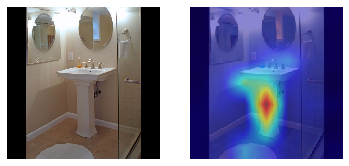

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,wash basin


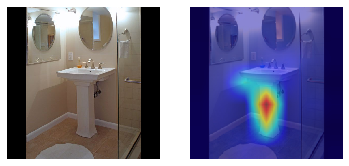

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,mirror


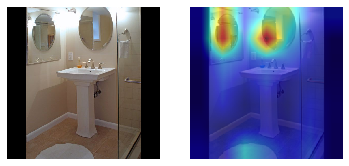

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,towel


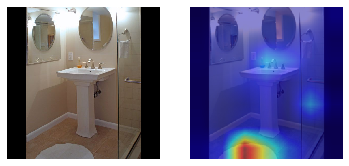

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,mirror


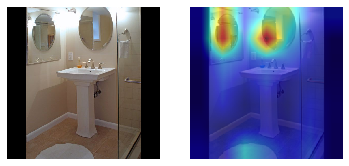

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,glass


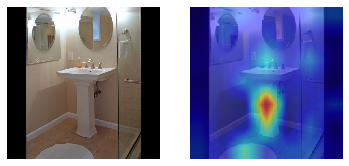

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,mat


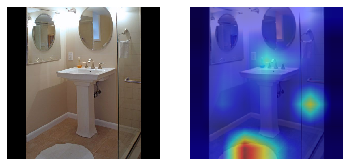

100


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,bed


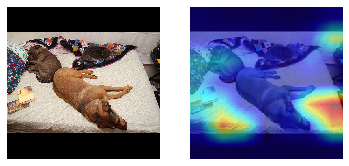

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,two dogs


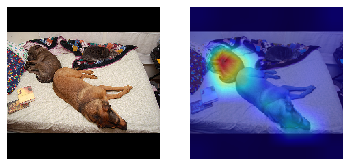

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,cat


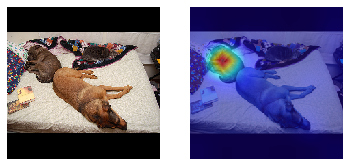

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,cushions


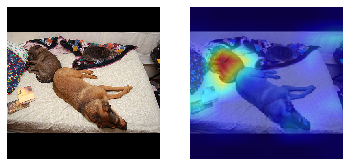

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,blankets


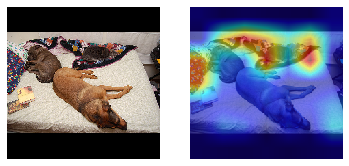

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,book


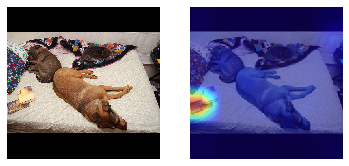

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,background walls


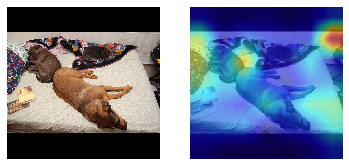

In [48]:
REPORT_SAMPLES_IDX = [9, 100]

for i in REPORT_SAMPLES_IDX:
    print(i)
    instance = dataset[i]
    
    for entry in instance:
        test_img, test_texts, orig_image = process_entry_text_to_image(entry)
        outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True)

## Unimodal Baseline

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,


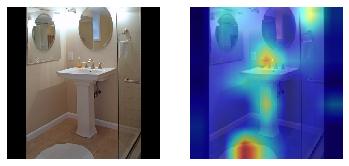

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,


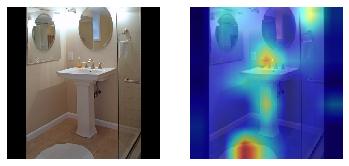

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,


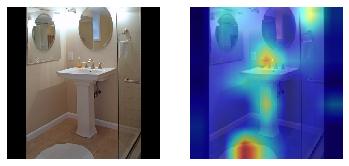

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,


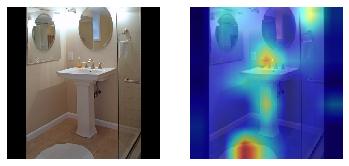

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,


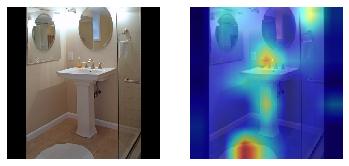

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,


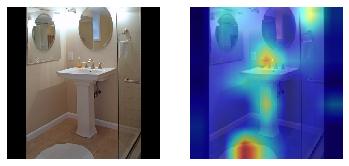

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,


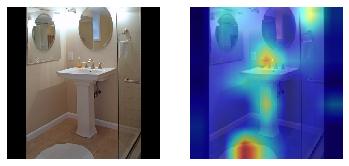

In [51]:
idx = 9
instance = dataset[idx]

for entry in instance:
    test_img, test_texts, orig_image = process_entry_text_to_image(entry, unimodal=True)
    outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True)

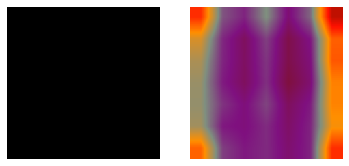

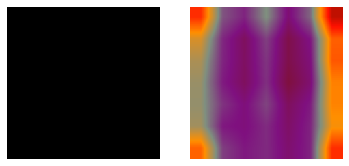

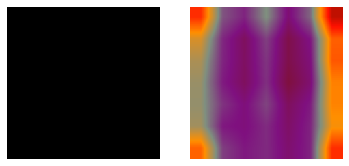

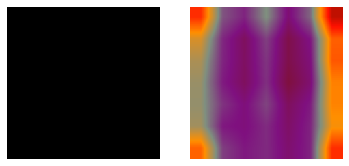

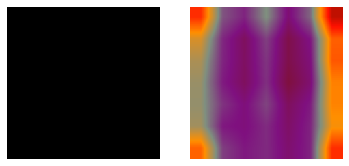

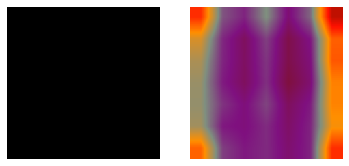

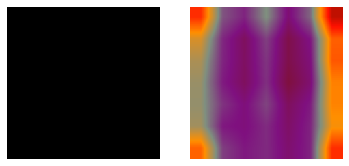

In [52]:


for entry in instance:
    img, texts, orig_image = process_entry_image_to_text(entry, unimodal=True)
    outputs = interpret_and_generate(model, img, texts, orig_image, return_outputs=True)